In [26]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('div.input').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Witness Analysis

Analyse number and gender of witnesses with respect to gender (and offence) of defendant

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [4]:
worddatafile="../../voa/OBV2/obv_words_v2_28-01-2017.tsv"
trialdatafile="../../voa/OBV2/obv_defendants_trials.tsv"
producersdatafile="../../voa/OBV2/obc2_producers.tsv"

proddata=pd.DataFrame.from_csv(producersdatafile,sep='\t')
worddata=pd.DataFrame.from_csv(worddatafile,sep='\t')
trialdata=pd.DataFrame.from_csv(trialdatafile,sep='\t')

/Users/juliewe/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2787: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Here is a sample of the words data

In [5]:
worddata.head()


,sess_date,year,obo_trial,obo_deftid,obc_u_no,obc_event,obc_speaker,obc_sex,obc_hiscoLabel,obc_hiscoCode,obc_class,obc_role,obv_role,words,obv_words_type,words_count,defendant
obv2wid,,,,,,,,,,,,,,,,,
1,17800112,1780,t17800112-1,NaN,1,17800112-1,17800112-0042,m,Working Proprietor (Guest House),51040.0,higher (1-5),NaN,wv,"I live at No. 7, in Great Suffolk-street, Char...",s,40,MARY DYER
2,17800112,1780,t17800112-1,NaN,2,17800112-2,17800112-?LAW,m,Lawyer,12110.0,higher (1-5),Lawyer,lj,Was that strange woman the prisoner?,q,6,MARY DYER
3,17800112,1780,t17800112-1,NaN,3,17800112-3,17800112-0042,m,Working Proprietor (Guest House),51040.0,higher (1-5),NaN,wv,Yes; she said she only wanted a pint of purl.,a,10,MARY DYER
4,17800112,1780,t17800112-1,NaN,4,17800112-4,17800112-?LAW,m,Lawyer,12110.0,higher (1-5),Lawyer,lj,Do you keep a public-house?,q,5,MARY DYER
5,17800112,1780,t17800112-1,NaN,5,17800112-5,17800112-0042,m,Working Proprietor (Guest House),51040.0,higher (1-5),NaN,wv,"No, a private house. I sent for a constable, a...",a,16,MARY DYER


First, we find the number of witnesses in each trial - first five displayed for reference.

In [6]:
witnessdata=worddata[worddata['obv_role']=="wv"]
witnessnumbers=witnessdata.groupby('obo_trial')['obc_speaker'].nunique()
witnessnumbers.head()

obo_trial
t17800112-1     3
t17800112-10    7
t17800112-11    2
t17800112-12    2
t17800112-13    1
Name: obc_speaker, dtype: int64

Then we find the number of female witnesses and the number of male witnesses in each trial - first five of each displayed below for reference.

In [7]:
femalewitnessdata=witnessdata[witnessdata['obc_sex']=='f']
malewitnessdata=witnessdata[witnessdata['obc_sex']=='m']
femalewitnessnumbers=femalewitnessdata.groupby('obo_trial')['obc_speaker'].nunique()
malewitnessnumbers=malewitnessdata.groupby('obo_trial')['obc_speaker'].nunique()

femalewitnessnumbers.head()

obo_trial
t17800112-1     1
t17800112-10    1
t17800112-15    1
t17800112-16    2
t17800112-20    3
Name: obc_speaker, dtype: int64

Then we need to find the trials which are for female defendants and the trials for male defendants.  The first five female defendant trials shown below.

In [8]:
speechattrialdata=trialdata[trialdata['trial_u_count']>0]

femaletrials=speechattrialdata[speechattrialdata['deft_gender']=='female']['obo_trial']
maletrials=speechattrialdata[speechattrialdata['deft_gender']=='male']['obo_trial']

In [9]:
femaletrials.head()

o2dtid
1      t17800112-1
4      t17800112-4
7      t17800112-7
8      t17800112-8
13    t17800112-15
Name: obo_trial, dtype: object

Then we hypothesize that the gender of a witness is independent of the gender of the defendant.  To test this we calculate the total number of witnesses for each gender of witness and gender of defendant.  This gives us a 2x2 contingency table - the first row is for female defendants, the first column is for female witnesses.

In [10]:
fwndict=femalewitnessnumbers.to_dict()
mwndict=malewitnessnumbers.to_dict()
XX={}
XY={}
YY={}
YX={}
Xprop={}
Xtot={}
Yprop={}
Ytot={}

for trial in femaletrials:
    XX[trial]=fwndict.get(trial,0)
    XY[trial]=mwndict.get(trial,0)
    Xtot[trial]=XX[trial]+XY[trial]
    if Xtot[trial]>0:
        Xprop[trial]=XX[trial]/Xtot[trial]
for trial in maletrials:
    YY[trial]=mwndict.get(trial,0)
    YX[trial]=fwndict.get(trial,0)
    Ytot[trial]=YY[trial]+YX[trial]
    if Ytot[trial]>0:
        Yprop[trial]=YX[trial]/Ytot[trial]

In [11]:
XXtot=sum(XX.values())
XYtot=sum(XY.values())
YXtot=sum(YX.values())
YYtot=sum(YY.values())

observed=[[XXtot,XYtot],[YXtot,YYtot]]
print(observed)

[[3048, 7878], [5768, 38314]]


Assuming independency of the variables, we calculate expected values (based on row and column totals) and carry out a chi-square test.


In [12]:
from scipy.stats import chi2_contingency
chi2_contingency(observed)

(1426.2828152291804, 0.0, 1, array([[  1751.08376963,   9174.91623037],
        [  7064.91623037,  37017.08376963]]))

So female witnesses much more likely when defendant is female.  When the defendant is female, the probability of a female witness increases from 0.16 to 0.28.  When the defendant is male, the probability that a witness is female decreases from 0.16 to 0.13.

However, the majority of female witnesses will still be talking about male defendants.  The probability the defendant is male is 0.65 for female witnesses and 0.83 for male witnesses.

Next, we will look more closely at the distribution of the proportions of female witnesses in trials for female defendants and for male defendants.  


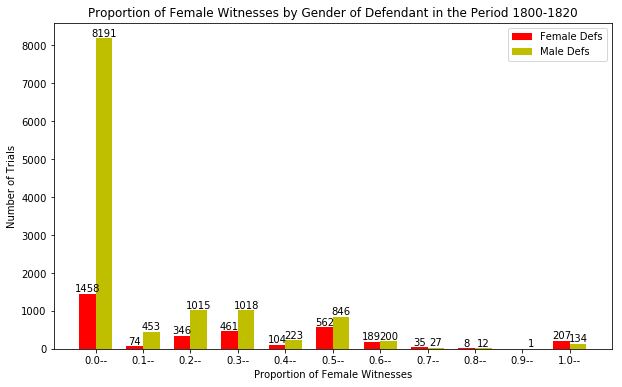

In [13]:

def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    
    for rect in rects:
        height = rect.get_height()
        if height>0:
            ax.text(rect.get_x() + rect.get_width()/2., height+0.5,
                    '%d' % int(height),
                    ha='center', va='bottom')

def bin_and_hist(adict,bdict):
    acountdict={}
    bcountdict={}
    for avalue in adict.values():
        arvalue=int(avalue*10)/10
        acountdict[arvalue]=acountdict.get(arvalue,0)+1
    for bvalue in bdict.values():
        brvalue=int(bvalue*10)/10
        bcountdict[brvalue]=bcountdict.get(brvalue,0)+1
        
   # print(acountdict,bcountdict)
    
    ind=list(acountdict.keys())
    for key in bcountdict.keys():
        if key not in ind:
            ind.append(key)
            
    ind=sorted(ind)
    #print(ind)
    values1=[]
    values2=[]
    labels=[]
    for i in ind:
        values1.append(acountdict.get(i,0))
        values2.append(bcountdict.get(i,0))
        labels.append("{:1.1f}--".format(i))
    
    width=0.035
    fig, ax = plt.subplots(figsize=(10,6))
    rects1 = ax.bar(ind, values1, width, color='r')
    rects2 = ax.bar([i + width for i in ind], values2, width, color='y')
    ax.set_xlabel('Proportion of Female Witnesses')
    ax.set_ylabel('Number of Trials')
    ax.set_title('Proportion of Female Witnesses by Gender of Defendant in the Period 1800-1820')
    ax.set_xticks([i + width / 2 for i in ind])
    ax.set_xticklabels(labels)

    ax.legend((rects1[0], rects2[0]), ('Female Defs', 'Male Defs'))
    
    autolabel(rects1,ax)
    autolabel(rects2,ax)
    plt.show()
    
bin_and_hist(Xprop,Yprop)

There are a large number of trials of both females and males where the witnesses are exclusively male.  However, this bias is strongest for male defendants.  There are more trials of women than of men where the witnesses are exclusively female (despite the fact that there are vastly mroe trials of male defendants).  This biased gender distribution of witnesses does suggest it is likely that we will find men talking more about men and women talking more about women.

##  Number of Witnesses
Does the number of witnesses in a trial depend on the gender of defendant or witness?  

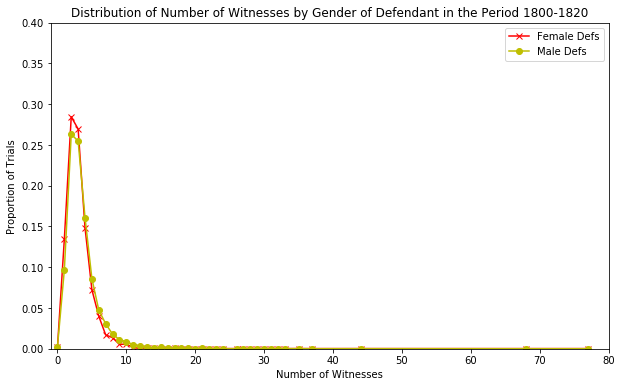

In [14]:
import math

wndict=witnessnumbers.to_dict()
Xcountdict={}
Ycountdict={}


for trial in femaletrials:
    #print(trial)
    X=wndict.get(trial,0)
    Xcountdict[X]=Xcountdict.get(X,0)+1
for trial in maletrials:
    Y=wndict.get(trial,0)
    Ycountdict[Y]=Ycountdict.get(Y,0)+1
    
ind=list(Xcountdict.keys())
for key in Ycountdict.keys():
    if key not in ind:
        ind.append(key)
        
ind=sorted(ind)
Xtot=sum(Xcountdict.values())
Ytot=sum(Ycountdict.values())
values1=[]
values2=[]
for i in ind:
    values1.append(Xcountdict.get(i,1)/Xtot)
    values2.append(Ycountdict.get(i,1)/Ytot)

    
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.plot(ind, values1, '-x', color='r')
rects2 = ax.plot(ind, values2, '-o', color='y')
ax.set_xlabel('Number of Witnesses')
ax.set_ylabel('Proportion of Trials')
ax.set_title('Distribution of Number of Witnesses by Gender of Defendant in the Period 1800-1820')
#ax.set_xticks([i + width / 2 for i in ind])
#ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0]), ('Female Defs', 'Male Defs'))
ax.set_xlim(-1,80)
ax.set_ylim(0,0.4)
    
plt.show()

These distributions look very similar.  Therefore there does not appear to be a strong connection between gender of defendant and number of witnesses.  There is a slightly higher probability of 0 witnesses in male cases (and corresponding higher probabilities for 1,2 and 3 witnesses in female cases).  However, the peak at 0 witnesses looks like an anomaly and is probably due to the cases where very little has actually been recorded (i.e. there probably were witnesses but there speech was not recorded).

Lets remove the trials where there is no speech at the trial.


In [15]:
speechattrialdata=worddata.groupby('obo_trial')['obc_event'].nunique().to_dict()
#print(speechattrialdata)

Repeating the chi square test on a 2x2 contingency table, we get much the same result as before.

In [16]:
#speechattrialdata=trialdata[trialdata['trial_u_count']>1]

femaletrials=trialdata[trialdata['deft_gender']=='female']['obo_trial']
maletrials=trialdata[trialdata['deft_gender']=='male']['obo_trial']

fwndict=femalewitnessnumbers.to_dict()
mwndict=malewitnessnumbers.to_dict()
XX={}
XY={}
YY={}
YX={}
Xprop={}
Xtot={}
Yprop={}
Ytot={}
threshold=0
nospeechattrial=[]
for trial in femaletrials:
    if speechattrialdata.get(trial,0)>threshold:
        XX[trial]=fwndict.get(trial,0)
        XY[trial]=mwndict.get(trial,0)
        Xtot[trial]=XX[trial]+XY[trial]
        if Xtot[trial]>0:
            Xprop[trial]=XX[trial]/Xtot[trial]
    else:
        nospeechattrial.append(trial)
for trial in maletrials:
    if speechattrialdata.get(trial,0)>threshold:
        YY[trial]=mwndict.get(trial,0)
        YX[trial]=fwndict.get(trial,0)
        Ytot[trial]=YY[trial]+YX[trial]
        if Ytot[trial]>0:
            Yprop[trial]=YX[trial]/Ytot[trial]
    else:
        nospeechattrial.append(trial)
XXtot=sum(XX.values())
XYtot=sum(XY.values())
YXtot=sum(YX.values())
YYtot=sum(YY.values())

observed=[[XXtot,XYtot],[YXtot,YYtot]]
print("Observed values:")
print(observed)

print("Chi-square results:")
chi2_contingency(observed)

Observed values:
[[3048, 7878], [5768, 38314]]
Chi-square results:


(1426.2828152291804, 0.0, 1, array([[  1751.08376963,   9174.91623037],
        [  7064.91623037,  37017.08376963]]))

We also see that the distribution of proportion of female witnesses remains the same (since we have just removed cases where there were no witnesses).

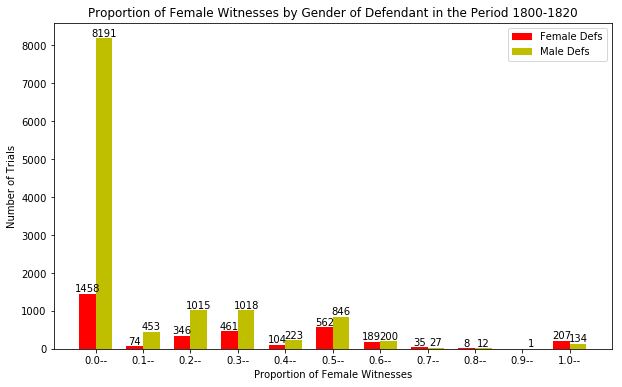

In [17]:
bin_and_hist(Xprop,Yprop)

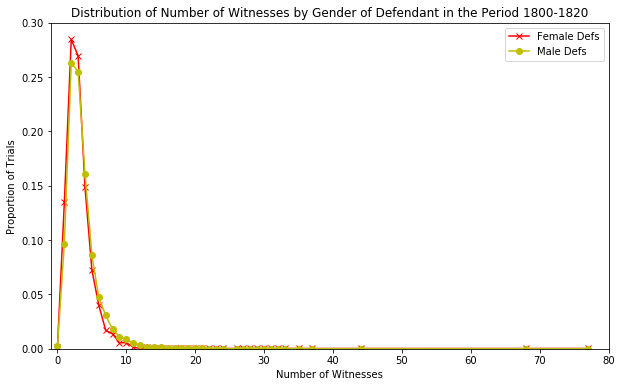

In [18]:
Xcountdict={}
Ycountdict={}


for trial in femaletrials:
    #print(trial)
    if speechattrialdata.get(trial,0)>threshold:
        X=wndict.get(trial,0)
        Xcountdict[X]=Xcountdict.get(X,0)+1
for trial in maletrials:
    if speechattrialdata.get(trial,0)>threshold:
        Y=wndict.get(trial,0)
        Ycountdict[Y]=Ycountdict.get(Y,0)+1
    
ind=list(Xcountdict.keys())
for key in Ycountdict.keys():
    if key not in ind:
        ind.append(key)
        
ind=sorted(ind)
Xtot=sum(Xcountdict.values())
Ytot=sum(Ycountdict.values())
values1=[]
values2=[]
for i in ind:
    values1.append(Xcountdict.get(i,1)/Xtot)
    values2.append(Ycountdict.get(i,1)/Ytot)

    
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.plot(ind, values1, '-x', color='r')
rects2 = ax.plot(ind, values2, '-o', color='y')
ax.set_xlabel('Number of Witnesses')
ax.set_ylabel('Proportion of Trials')
ax.set_title('Distribution of Number of Witnesses by Gender of Defendant in the Period 1800-1820')
#ax.set_xticks([i + width / 2 for i in ind])
#ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0]), ('Female Defs', 'Male Defs'))
ax.set_xlim(-1,80)
ax.set_ylim(0,0.3)
    
plt.show()

However, now the distribution of the number of witnesses looks much like we would expect with the anomalous peak at 0 removed.

In [19]:
#print(nospeechattrial)


In [20]:
someworddata=worddata[worddata['obo_trial'].isin(nospeechattrial)]
someworddata.head()

,sess_date,year,obo_trial,obo_deftid,obc_u_no,obc_event,obc_speaker,obc_sex,obc_hiscoLabel,obc_hiscoCode,obc_class,obc_role,obv_role,words,obv_words_type,words_count,defendant
obv2wid,,,,,,,,,,,,,,,,,


For reference, here are the first 5 trials with no speech recorded.

In [21]:
nospeechtrialdata=trialdata[trialdata['obo_trial'].isin(nospeechattrial)]
nospeechtrialdata.head()

,obo_trial,obo_deftid,sess_date,year,trial_tagged,obv_def_spk,speech,trial_u_count,trial_speech_wc,trial_total_wc,...,deft_surname,deft_gender,deft_age,deft_occupation,deft_offcat,deft_offsub,deft_vercat,deft_versub,deft_puncat,deft_punsub
o2dtid,,,,,,,,,,,,,,,,,,,,,
40,t17800223-13,t17800223-13-defend191,17800223,1780,0,NaN,no_speech,NaN,NaN,206,...,POWELL,male,NaN,NaN,theft,pocketpicking,notGuilty,NaN,NaN,NaN
56,t17800223-32,t17800223-32-defend379,17800223,1780,0,NaN,no_speech,NaN,NaN,43,...,DAVISON,female,NaN,NaN,theft,grandLarceny,notGuilty,fault,NaN,NaN
66,t17800223-46,t17800223-46-defend529,17800223,1780,0,NaN,no_speech,NaN,NaN,56,...,STAMFORD,male,NaN,NaN,theft,grandLarceny,notGuilty,noProsecutor,NaN,NaN
77,t17800405-5,t17800405-5-defend88,17800405,1780,0,NaN,no_speech,NaN,NaN,54,...,STEWARD,female,NaN,NaN,theft,grandLarceny,notGuilty,NaN,NaN,NaN
101,t17800405-34,t17800405-34-defend456,17800405,1780,0,NaN,no_speech,NaN,NaN,49,...,M'CLOCKLAN,female,NaN,NaN,theft,grandLarceny,notGuilty,noProsecutor,NaN,NaN


Removing the trials with no speech, we see that we remove all of the cases where there are no witnesses.
The distribution of number of witnesses is very similar for males and females (with a slightly higher probability of a smaller number of witnesses in female cases).


Finally, lets look at the distribution of the number of witnesses given the gender of a witness.  If there are 8 witnesses in a trial and 3 of them are female then we record this as 3 occurrences of 8 witnesses when a witness is female (and 5 occurrences of 8 witnesses when a witness is male).  Hence, we have the probability of the number of witnesses in a trial given the gender of a particular witness.

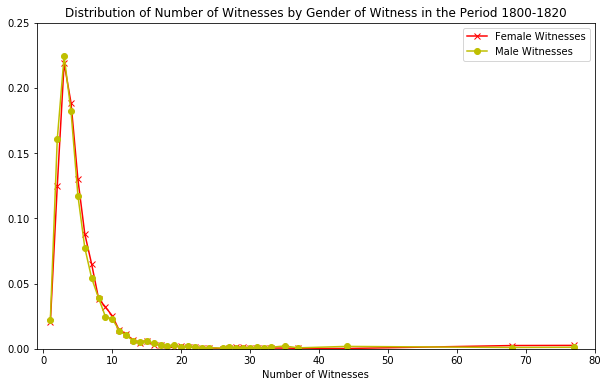

In [22]:
fwitcountdict={}
mwitcountdict={}

for trial in fwndict.keys():
    if trial in speechattrialdata:
        witnesses=wndict[trial]
        femalewitnesses=fwndict[trial]
        fwitcountdict[witnesses]=fwitcountdict.get(witnesses,0)+femalewitnesses

for trial in mwndict.keys():
    if trial in speechattrialdata:
        witnesses=wndict[trial]
        malewitnesses=mwndict[trial]
        mwitcountdict[witnesses]=mwitcountdict.get(witnesses,0)+malewitnesses
        
ind=list(fwitcountdict.keys())
for key in mwitcountdict.keys():
    if key not in ind:
        ind.append(key)
        
ind=sorted(ind)
Xtot=sum(fwitcountdict.values())
Ytot=sum(mwitcountdict.values())
values1=[]
values2=[]
for i in ind:
    values1.append(fwitcountdict.get(i,1)/Xtot)
    values2.append(mwitcountdict.get(i,1)/Ytot)

    
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.plot(ind, values1, '-x', color='r')
rects2 = ax.plot(ind, values2, '-o', color='y')
ax.set_xlabel('Number of Witnesses')
#ax.set_ylabel('Proportion of Trials')
ax.set_title('Distribution of Number of Witnesses by Gender of Witness in the Period 1800-1820')
#ax.set_xticks([i + width / 2 for i in ind])
#ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0]), ('Female Witnesses', 'Male Witnesses'))
ax.set_xlim(-1,80)
ax.set_ylim(0,0.25)
    
plt.show()

Gender of witness does not appear to have an impact on the number of witnesses i.e., female and male witnesses appear equally likely to appear in cases with different numbers of witnesses.